# 动手学深度学习 章节7.3 网络中的网络 (NiN) 示例代码

In [1]:
import torch
from torch import nn

定义一个NiN块

In [2]:
def nin_block(in_channels:int, out_channels:int, kernel_size, strides, padding):
	"""
	定义一个NiN块

	Args:
		in_channels: 输入通道数
		out_channels: 输出通道数
		kernel_size: 卷积核大小
		strides: 步长
		padding: 填充
	"""
	return nn.Sequential(
		nn.Conv2d(in_channels, out_channels, kernel_size, strides, padding), nn.ReLU(),
		nn.Conv2d(out_channels, out_channels, kernel_size=1), nn.ReLU(),
		nn.Conv2d(out_channels, out_channels, kernel_size=1), nn.ReLU()
	)


定义一个NiN模型

In [3]:
class NiN(nn.Module):
	"""
	NiN网络
	"""
	def __init__(self, *args, **kwargs) -> None:
		super().__init__(*args, **kwargs)
		net = nn.Sequential(
			nin_block(1, 96, 11, 4, 0),
			nn.MaxPool2d(3, stride=2),
			nin_block(96, 256, 5, 1, 2),
			nn.MaxPool2d(3, stride=2),
			nin_block(256, 384, 3, 1, 1),
			nn.MaxPool2d(3, stride=2),
			nn.Dropout(0.5),
			nin_block(384, 10, 3, 1, 1),
			nn.AdaptiveAvgPool2d((1, 1)),
			nn.Flatten()
		)

		for index, layer in enumerate(net):
			if isinstance(layer, nn.Sequential):
				self._modules[f'NiN{index}'] = layer
			else:
				self._modules[f"{layer.__class__.__name__}{index}"] = layer


	def forward(self, X):
		for name, layer in self._modules.items():
			X = layer(X)	# type: ignore

		return X


	def __iter__(self):
		return self._modules.values().__iter__()

In [4]:
model = NiN()

X = torch.randn([1, 1, 224, 224])
print(X.shape)
for layer in model:
	X = layer(X)	# type: ignore
	print(layer.__class__.__name__, 'output shape:\t', X.shape)

torch.Size([1, 1, 224, 224])
Sequential output shape:	 torch.Size([1, 96, 54, 54])
MaxPool2d output shape:	 torch.Size([1, 96, 26, 26])
Sequential output shape:	 torch.Size([1, 256, 26, 26])
MaxPool2d output shape:	 torch.Size([1, 256, 12, 12])
Sequential output shape:	 torch.Size([1, 384, 12, 12])
MaxPool2d output shape:	 torch.Size([1, 384, 5, 5])
Dropout output shape:	 torch.Size([1, 384, 5, 5])
Sequential output shape:	 torch.Size([1, 10, 5, 5])
AdaptiveAvgPool2d output shape:	 torch.Size([1, 10, 1, 1])
Flatten output shape:	 torch.Size([1, 10])


训练模型

Finally test acc is 0.8783052884615384


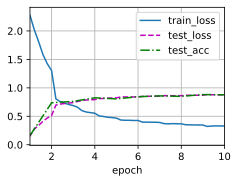

In [5]:
from utils.data.mnist import load_data_fashion_mnist
from utils.train.d2l_train import train_convolution_network

lr, num_epoch, batch_size = 0.1, 10, 128

train_loader, test_loader = load_data_fashion_mnist(batch_size, resize=224)
train_convolution_network(model, train_loader, test_loader, num_epoch, lr)